In [8]:
%load_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Images/data for thesis text

In [9]:
import os, sys
import numpy as np
import pandas as pd
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('../..')))

import plot.anomalies, plot.data
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
import pipeline.pipeline as pipeline
from postprocessing import segmentation
from evaluation import evaluation
from preprocessing import feature_extraction, preprocessing

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [14]:
df = feature_extraction.load_features_from_file(beam=1)
labels_b1 = feature_extraction.load_logbook_from_file(beam=1)
labels_b2 = feature_extraction.load_logbook_from_file(beam=2)

Loading file '/Users/thiebout/master/anomaly-detection-mki-2019/src/../data-cern/features_B1.csv'.
Loading file '/Users/thiebout/master/anomaly-detection-mki-2019/src/../data-cern/logbook_B1.csv'.
Loading file '/Users/thiebout/master/anomaly-detection-mki-2019/src/../data-cern/logbook_B2.csv'.


### Table of counts for different types of labels

In [15]:
labels_b1.groupby("TAG").sum()

EVENT_ID  BEAM
TAG                          
anomaly        69243552    31
fault          37979133    17
info          170464772    76
intervention   83336480    37
research        2151999     1

In [16]:
labels_b2.groupby("TAG").sum()

EVENT_ID  BEAM
TAG                          
anomaly        26736855    24
fault          42302888    38
info          128993421   114
intervention   74324939    66
research        4201819     4

In [31]:
# Checking labels to see reason for temperature drop in early may
display(labels_b1["2016-05-02"],labels_b2["2016-05-02"])

SUBSTR_COMMENT_512_  \
timestamps                                                               
2016-05-02 10:00:00  Stopped the MKI2 today around 12.00 am to 'bur...   

                              TAG                     USERNAME VALUE  \
timestamps                                                             
2016-05-02 10:00:00  intervention  roger.andrew.barlow@cern.ch  MKI2   

                         PATH  EVENT_ID            EVENTDATE  BEAM  
timestamps                                                          
2016-05-02 10:00:00  LHC.MKI2   2104505  02/05/2016 12:00:00     1

SUBSTR_COMMENT_512_  \
timestamps                                                               
2016-05-02 12:59:00  Stopped the MKI8 today around 12.00 am to 'bur...   

                              TAG                     USERNAME VALUE  \
timestamps                                                             
2016-05-02 12:59:00  intervention  roger.andrew.barlow@cern.ch  MKI8   

                         PATH  EVENT_ID            EVENTDATE  BEAM  
timestamps                                                          
2016-05-02 12:59:00  LHC.MKI8   2104506  02/05/2016 14:59:00     2

### Continuous data timestamps

In [32]:
a = db.query("A5L2.B1:(PRESSURE|TEMP_TUBE_UP|TEMP_TUBE_DOWN)", "2016-07-05",  "2016-07-06", fillna=False)
b = db.query("B1:BEAM_INTENSITY", "2016-07-05",  "2016-07-06", fillna=False)

display(a.head(), b.head())

Fetching data for pattern A5L2.B1:(PRESSURE|TEMP_TUBE_UP|TEMP_TUBE_DOWN) from 2016-07-05 to 2016-07-06

Fetching data for pattern B1:BEAM_INTENSITY from 2016-07-05 to 2016-07-06



series                         MKI.A5L2.B1:TEMP_TUBE_DOWN  \
timestamps                                                  
2016-07-05 00:00:15.076999903                        48.6   
2016-07-05 00:04:21.132999897                         NaN   
2016-07-05 00:14:35.259999990                         NaN   
2016-07-05 00:15:15.269000053                        48.8   
2016-07-05 00:17:15.292999983                         NaN   

series                         MKI.A5L2.B1:TEMP_TUBE_UP  MKI.A5L2.B1:PRESSURE  
timestamps                                                                     
2016-07-05 00:00:15.076999903                       NaN                   NaN  
2016-07-05 00:04:21.132999897                      95.1                   NaN  
2016-07-05 00:14:35.259999990                       NaN          1.080000e-10  
2016-07-05 00:15:15.269000053                       NaN                   NaN  
2016-07-05 00:17:15.292999983                      95.7                   NaN

series                         LHC.BCTFR.A6R4.B1:BEAM_INTENSITY
timestamps                                                     
2016-07-05 00:00:00.691999912                      2.257232e+14
2016-07-05 00:00:01.711999893                      2.257254e+14
2016-07-05 00:00:02.732000113                      2.257220e+14
2016-07-05 00:00:03.752000093                      2.257213e+14
2016-07-05 00:00:04.772000074                      2.257215e+14

In [34]:
a = db.query("A5L2.B1:(PRESSURE|TEMP_TUBE_UP|TEMP_TUBE_DOWN)", "2016-07-05",  "2016-07-06", fillna=True)
b = db.query("B1:BEAM_INTENSITY", "2016-07-05",  "2016-07-06", fillna=True)

display(a.head(), b["2016-07-05 00:00:15"], b["2016-07-05 00:00:17"])

Fetching data for pattern A5L2.B1:(PRESSURE|TEMP_TUBE_UP|TEMP_TUBE_DOWN) from 2016-07-05 to 2016-07-06

Fetching data for pattern B1:BEAM_INTENSITY from 2016-07-05 to 2016-07-06



series                         MKI.A5L2.B1:TEMP_TUBE_DOWN  \
timestamps                                                  
2016-07-05 00:00:15.076999903                        48.6   
2016-07-05 00:04:21.132999897                        48.6   
2016-07-05 00:14:35.259999990                        48.6   
2016-07-05 00:15:15.269000053                        48.8   
2016-07-05 00:17:15.292999983                        48.8   

series                         MKI.A5L2.B1:TEMP_TUBE_UP  MKI.A5L2.B1:PRESSURE  
timestamps                                                                     
2016-07-05 00:00:15.076999903                      95.1          1.080000e-10  
2016-07-05 00:04:21.132999897                      95.1          1.080000e-10  
2016-07-05 00:14:35.259999990                      95.1          1.080000e-10  
2016-07-05 00:15:15.269000053                      95.1          1.080000e-10  
2016-07-05 00:17:15.292999983                      95.7          1.080000e-10

series                         LHC.BCTFR.A6R4.B1:BEAM_INTENSITY
timestamps                                                     
2016-07-05 00:00:15.993000031                      2.257001e+14

series                         LHC.BCTFR.A6R4.B1:BEAM_INTENSITY
timestamps                                                     
2016-07-05 00:00:17.013000011                      2.256982e+14

#### IPOC data close up

Fetching data for pattern IPOC.AB1 from 2016-07-01 to 2016-07-25



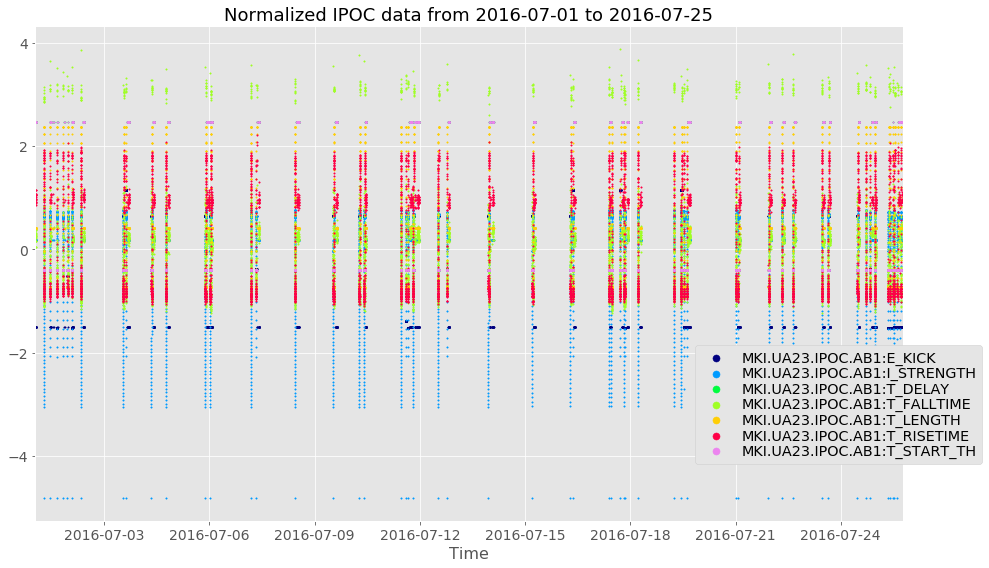

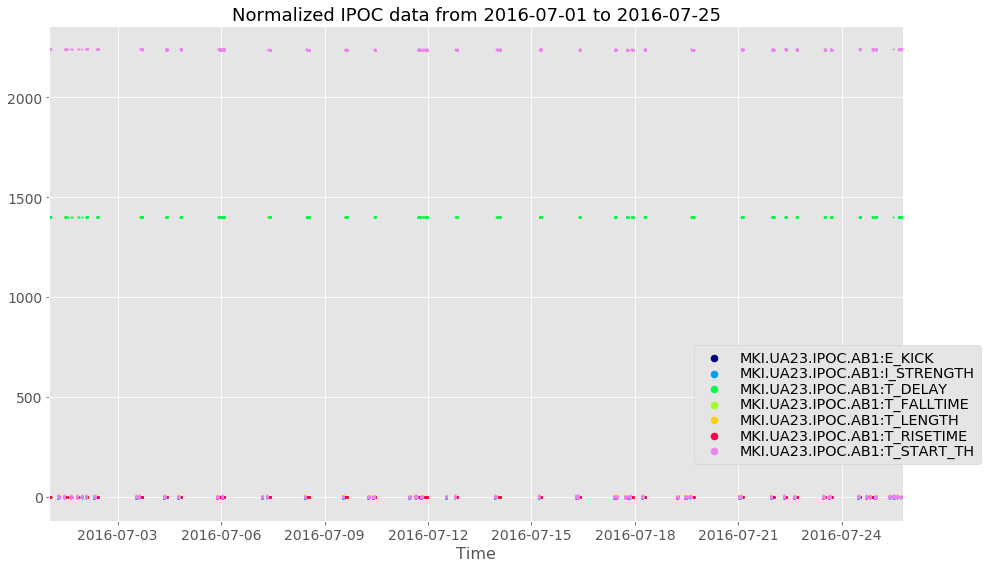

In [37]:
f = "2016-07-01"
t = "2016-07-25"
a = db.query("IPOC.AB1", f, t, filters=True)
plot.data.ipoc(preprocessing.scale(a), "Normalized IPOC data from {} to {}".format(f, t))
plot.data.ipoc(preprocessing.scale_robust(a), "Normalized IPOC data from {} to {}".format(f, t))